In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt

In [2]:
tensor_transform = transforms.ToTensor()
dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=tensor_transform)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

testset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=tensor_transform)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=1000, shuffle=False)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device is set to: {device}")

Device is set to: mps


## MLP

In [4]:
class AESimple(torch.nn.Module):
    def __init__(self, latent_dim):
        super(AESimple, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28 * 28, self.latent_dim),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, 28 * 28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        reshaped = torch.reshape(decoded, (-1, 1, 28, 28))
        return reshaped

In [5]:
simple = AESimple(128)
summary(simple, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 784]         101,136
           Sigmoid-5                  [-1, 784]               0
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.77
Estimated Total Size (MB): 0.79
----------------------------------------------------------------


In [6]:
def train_eval(epochs, lr, model, loader, testloader):
    pelosses = []
    pelosses_test = []

    model = model.to(device)
    loss_function = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  #, weight_decay = 1e-8)

    for epoch in range(epochs):
        peloss = 0.0
        for (image, _) in loader:
            image = image.to(device)
            reconstructed = model(image)
            loss = loss_function(reconstructed, image)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            peloss += loss.item()
        peloss /= len(loader)
        pelosses.append(peloss)

        pelosstest = 0.0
        with torch.no_grad():
            for (image, _) in testloader:
                image = image.to(device)
                reconstructed = model(image)
                pelosstest += loss_function(reconstructed, image).item()
            pelosstest /= len(testloader)
            pelosses_test.append(pelosstest)
        print("Epoch %i: train_loss=%6.4f  test_loss=%6.4f" % (epoch+1, peloss, pelosstest))
    return pelosses, pelosses_test

In [7]:
def plot_loss(pelosses, pelosses_test):
    plt.style.use('fivethirtyeight')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Loss over epochs")
    epochs = len(pelosses)
    plt.semilogy(torch.arange(epochs) + 1, pelosses, 'b-')
    plt.semilogy(torch.arange(epochs) + 1, pelosses_test, 'r-')

Epoch 1: train_loss=0.0220  test_loss=0.0119
Epoch 2: train_loss=0.0103  test_loss=0.0092
Epoch 3: train_loss=0.0086  test_loss=0.0083
Epoch 4: train_loss=0.0080  test_loss=0.0078
Epoch 5: train_loss=0.0076  test_loss=0.0075
Epoch 6: train_loss=0.0074  test_loss=0.0074
Epoch 7: train_loss=0.0073  test_loss=0.0074
Epoch 8: train_loss=0.0072  test_loss=0.0072
Epoch 9: train_loss=0.0072  test_loss=0.0072
Epoch 10: train_loss=0.0071  test_loss=0.0072
Epoch 11: train_loss=0.0071  test_loss=0.0072
Epoch 12: train_loss=0.0070  test_loss=0.0073
Epoch 13: train_loss=0.0070  test_loss=0.0071
Epoch 14: train_loss=0.0070  test_loss=0.0071
Epoch 15: train_loss=0.0070  test_loss=0.0073


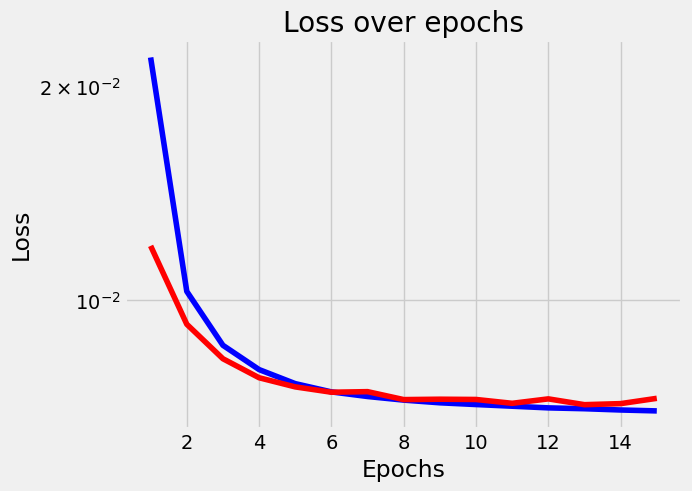

In [8]:
nepochs = 15
model = AESimple(128)
pelosses, pelosses_test = train_eval(nepochs, 0.001, model, loader, testloader)
plot_loss(pelosses, pelosses_test)

In [9]:
def reconstruct(img, model):
    img = model(img)
    return img


def plot_img(img, title):
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="Greys")


def plot_samples(dataset, models):
    n = 10
    m = len(models)
    indices = torch.randint(len(dataset), size=(n,))
    cols, rows = n, m + 1
    figure = plt.figure(figsize=(18, (m + 1) * 2))
    for i in range(n):
        idx = indices[i].item()
        img, label = dataset[idx]
        figure.add_subplot(rows, cols, i + 1)
        plot_img(img.numpy(), "")

        for j in range(m):
            figure.add_subplot(rows, cols, (j + 1) * n + i + 1)
            img, label = dataset[idx]
            img = reconstruct(img, models[j].to("cpu")).detach().numpy()
            plot_img(img, "")

    plt.show()

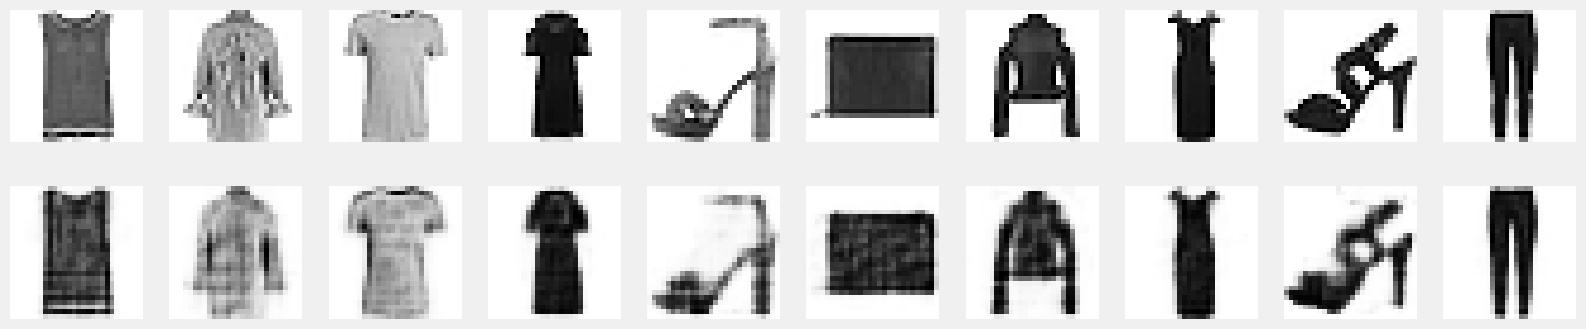

In [10]:
plot_samples(testset, [model])

In [11]:
def interpolate(img1, img2, model, d):
    n = 20
    lrow = int(n / 2)

    model = model.to("cpu")

    img1 = img1.view(-1, 1, 28 * 28)
    z1 = model.encoder(img1)

    z1 = z1.view(-1, d)
    rec1 = model.decoder(z1)
    img2 = img2.view(-1, 28 * 28)
    z2 = model.encoder(img2)
    z2 = z2.view(-1, d)
    rec2 = model.decoder(z2)

    imgs = [img1.detach().numpy(), rec1.detach().numpy()]
    for i in range(n - 4):
        z = z1 + (z2 - z1) * i / (n - 4)
        img_dist = model.decoder(z).detach().numpy()
        imgs.append(img_dist)

    imgs.append(rec2.detach().numpy())
    imgs.append(img2.detach().numpy())

    plt.figure(figsize=(18, 4))
    for i in range(lrow):
        ax = plt.subplot(2, lrow, i + 1)
        plot_img(imgs[i].reshape(28, 28), "")

    for i in range(lrow):
        ax = plt.subplot(2, lrow, i + 1 + lrow)
        plot_img(imgs[lrow + i].reshape(28, 28), "")


plt.show()

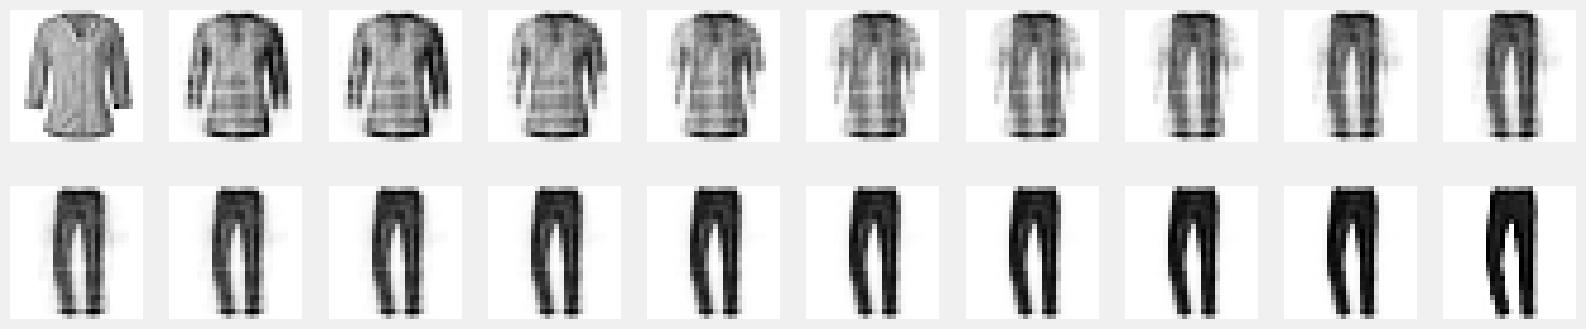

In [12]:
interpolate(testset[4][0], testset[2][0], model, 128)

In [13]:
def noise_added(inputs, model, sigma=0.2):
    n = 10
    m = len(inputs)
    to_plot = {}
    model = model.to("cpu")
    for j in range(m):
        img = inputs[j]
        z = model.encoder(img)
        rec = model.decoder(z)
        imgs = [img.detach().numpy(), rec.detach().numpy()]
        for i in range(n - 2):
            noise = sigma * torch.randn((model.latent_dim,))
            img_dist = model.decoder(z + noise).detach().numpy()
            imgs.append(img_dist)
        to_plot[j] = imgs

    plt.figure(figsize=(20, m * 2))
    ax = plt.subplot(m, n, 1)
    for j in range(m):
        for i in range(n):
            ax = plt.subplot(m, n, j * n + i + 1)
            plot_img(to_plot[j][i].reshape(28, 28), "")

    plt.show()

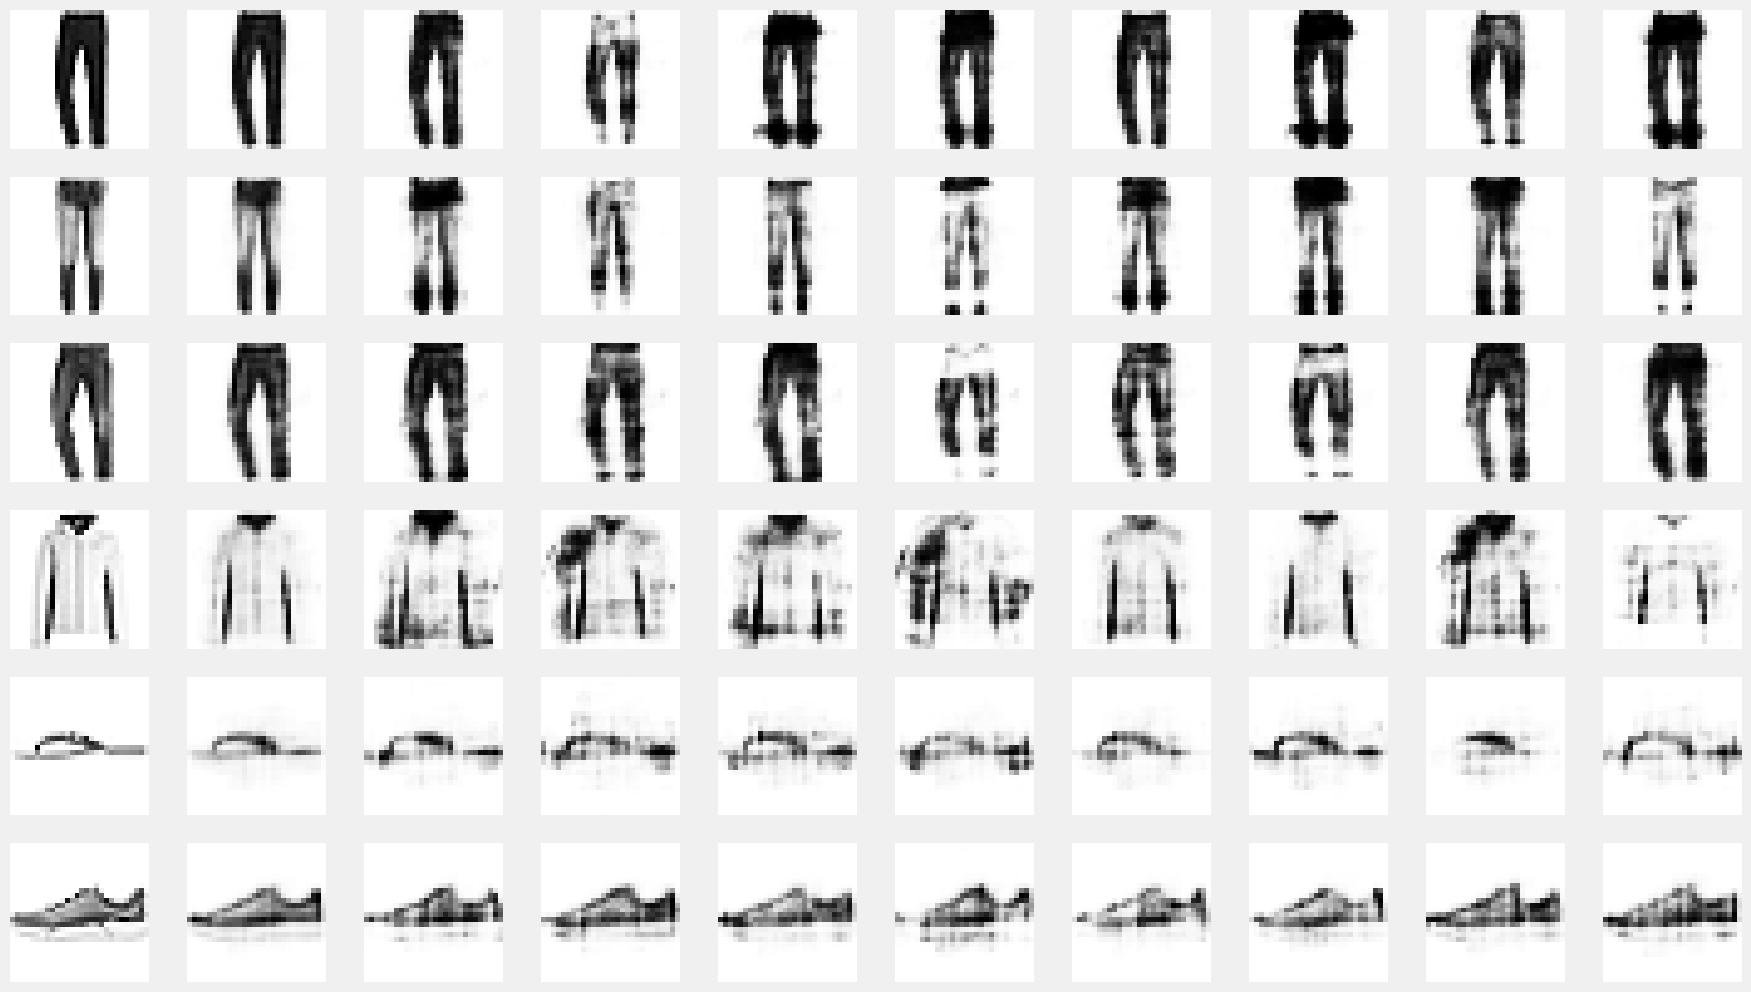

In [14]:
noise_added([testset[i][0] for i in [2, 3, 5, 6, 8, 9]], model, sigma=0.5)

In [15]:
def generated(model, ld=None):
    cols = 10
    rows = 6
    model = model.to("cpu")
    plt.figure(figsize=(20, rows * 2))
    ax = plt.subplot(rows, cols, 1)
    d = model.latent_dim if hasattr(model, "latent_dim") else ld
    for j in range(rows):
        for i in range(cols):
            z = torch.randn((d,)).view(-1, d)
            rec = model.decoder(z).detach().numpy()
            ax = plt.subplot(rows, cols, j * cols + i + 1)
            plot_img(rec.reshape(28, 28), "")

    plt.show()

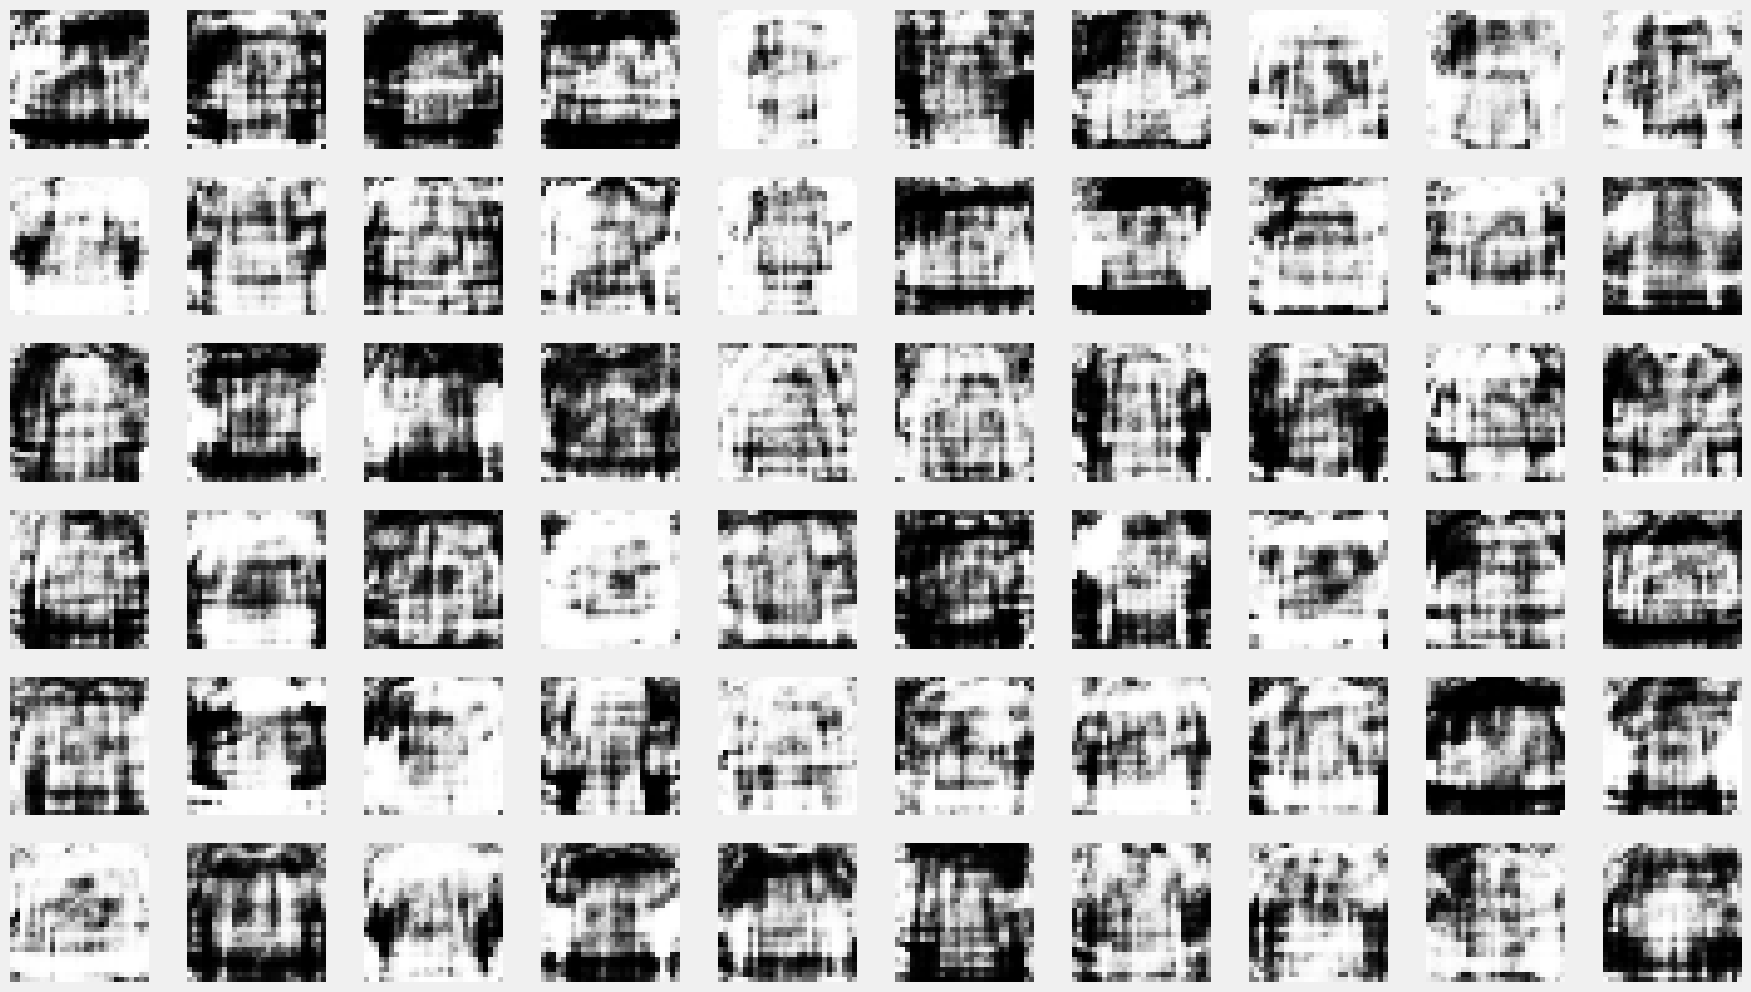

In [16]:
generated(model)

## CNN

In [17]:
class AECNN1(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.d = latent_dim // 4
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, self.d, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Flatten()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(self.d, 64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 1, kernel_size=5, stride=1),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        encoded = self.encoder(x)
        encoded = encoded.view(-1, self.d, 2, 2)
        reconstructed = self.decoder(encoded)
        return reconstructed

In [18]:
auto_encoder_cnn = AECNN1(128)
summary(auto_encoder_cnn, (1, 28, 28))
# output_size = (input_size - kernel_size + 2*padding) / stride + 1

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
              ReLU-2           [-1, 16, 24, 24]               0
            Conv2d-3           [-1, 32, 11, 11]           8,224
              ReLU-4           [-1, 32, 11, 11]               0
            Conv2d-5             [-1, 64, 5, 5]          18,496
              ReLU-6             [-1, 64, 5, 5]               0
            Conv2d-7             [-1, 32, 2, 2]          18,464
              ReLU-8             [-1, 32, 2, 2]               0
           Flatten-9                  [-1, 128]               0
  ConvTranspose2d-10             [-1, 64, 5, 5]          18,496
             ReLU-11             [-1, 64, 5, 5]               0
  ConvTranspose2d-12           [-1, 32, 11, 11]          18,464
             ReLU-13           [-1, 32, 11, 11]               0
  ConvTranspose2d-14           [-1, 16,

In [19]:
epochs = 15
lr = 0.001
model = AECNN1(128)
pelosses2, pelosses_test2 = train_eval(epochs, lr, model, loader, testloader)

Epoch 1: train_loss=0.0236  test_loss=0.0144
Epoch 2: train_loss=0.0126  test_loss=0.0112
Epoch 3: train_loss=0.0103  test_loss=0.0098
Epoch 4: train_loss=0.0092  test_loss=0.0089
Epoch 5: train_loss=0.0086  test_loss=0.0084
Epoch 6: train_loss=0.0081  test_loss=0.0081
Epoch 7: train_loss=0.0078  test_loss=0.0076
Epoch 8: train_loss=0.0075  test_loss=0.0074
Epoch 9: train_loss=0.0073  test_loss=0.0072
Epoch 10: train_loss=0.0072  test_loss=0.0072
Epoch 11: train_loss=0.0070  test_loss=0.0071
Epoch 12: train_loss=0.0069  test_loss=0.0069
Epoch 13: train_loss=0.0068  test_loss=0.0067
Epoch 14: train_loss=0.0067  test_loss=0.0067
Epoch 15: train_loss=0.0067  test_loss=0.0066


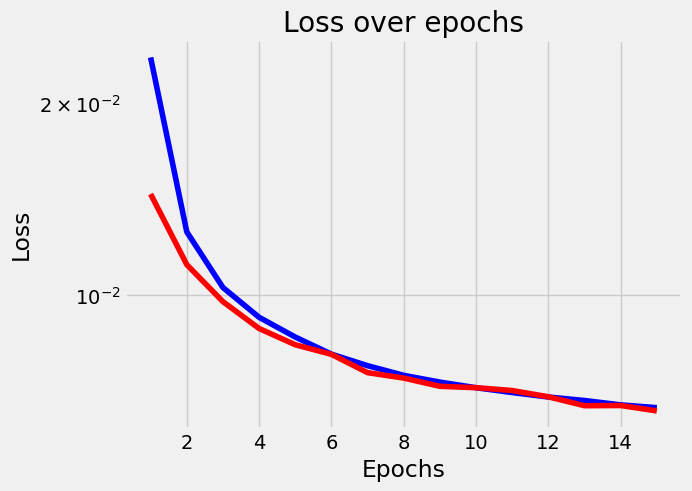

In [20]:
plot_loss(pelosses2, pelosses_test2)

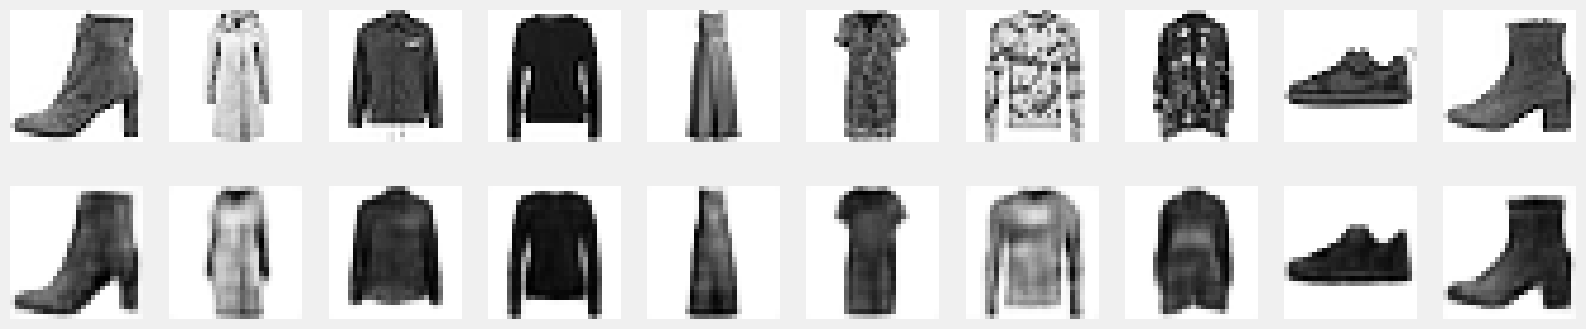

In [21]:
plot_samples(testset, [model])

In [22]:
def generated4cnn(model, ld=None):
    cols = 10
    rows = 6
    model = model.to("cpu")
    plt.figure(figsize=(20, rows * 2))
    ax = plt.subplot(rows, cols, 1)
    d = model.latent_dim if hasattr(model, "latent_dim") else ld
    for j in range(rows):
        for i in range(cols):
            z = torch.rand((d,)).view(-1, d // 4, 2, 2)
            rec = model.decoder(z).detach().numpy()
            # rec = rec.squeeze()
            ax = plt.subplot(rows, cols, j * cols + i + 1)
            plot_img(rec.reshape(28, 28), "")
    plt.show()

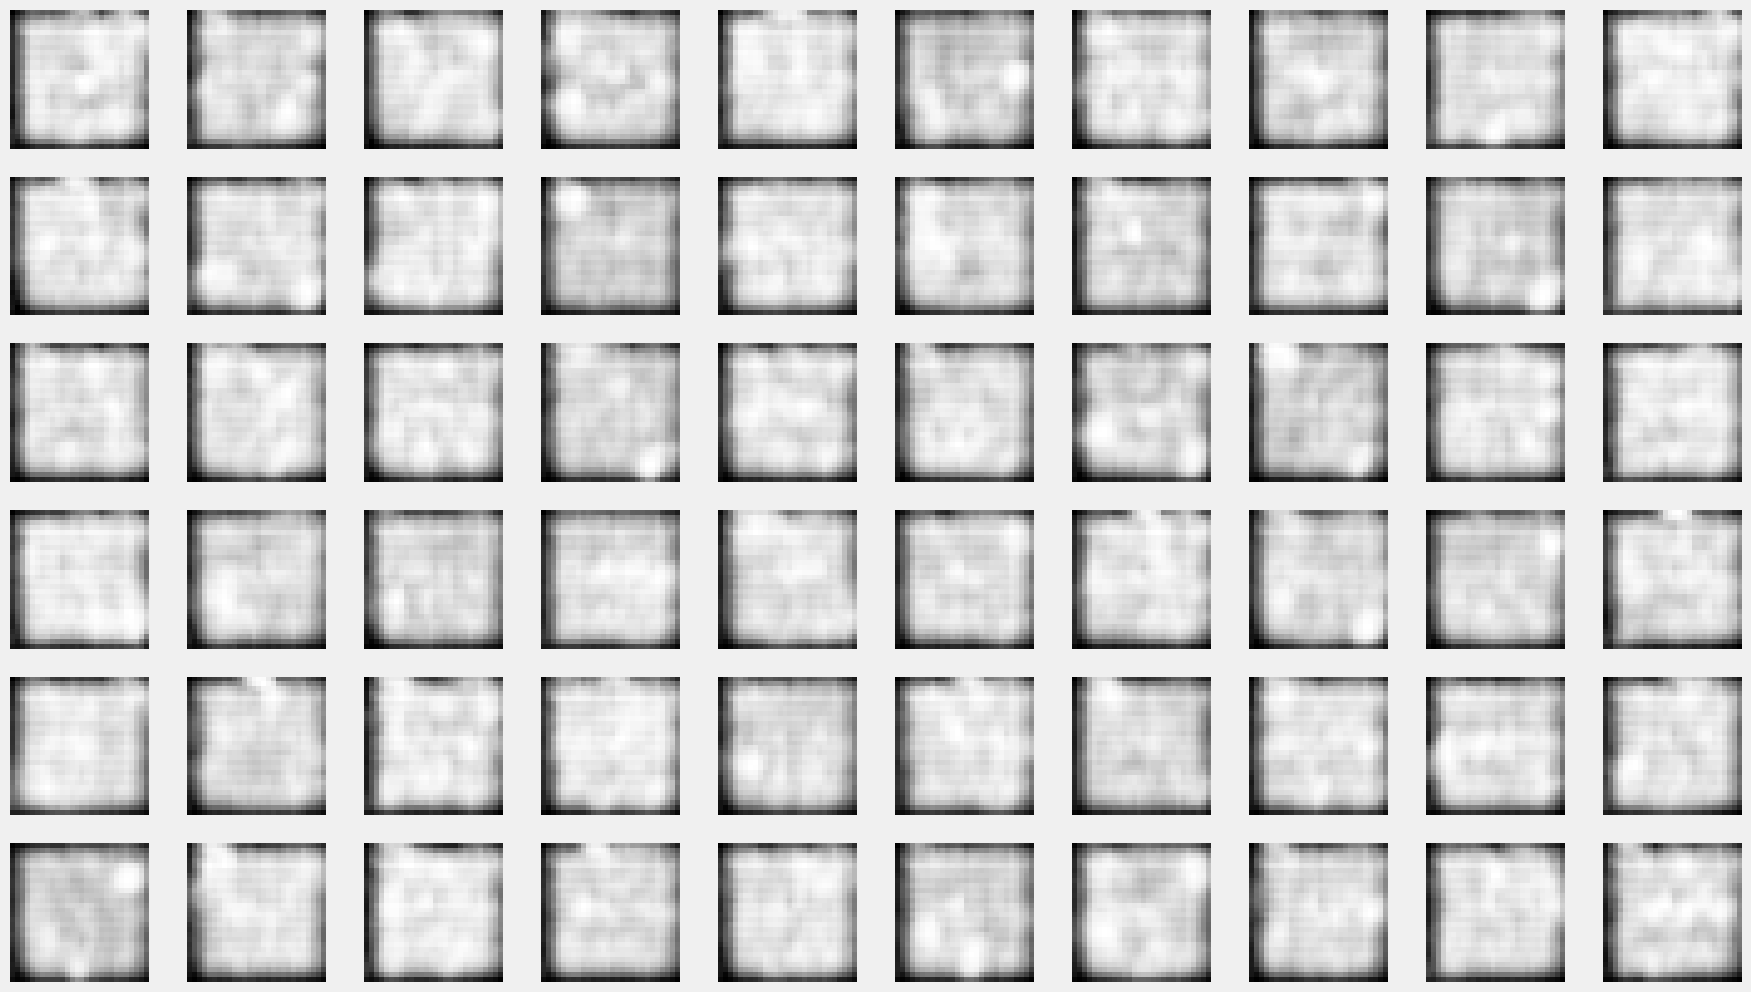

In [23]:
generated4cnn(model, 128)

### Conclusion
Both the MLP and CNN Autoencoder only genereate marginal difference in performance during training. The CNN AE has a slightly lower test loss with 0.0066. Both have been trained for 15 epochs.

## VAE

In [24]:
class VAECNN2(torch.nn.Module):
    def __init__(self, latent_dim, beta=1.0):
        super().__init__()
        self.d = latent_dim // 4
        self.beta = beta
        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=self.d, kernel_size=3, stride=2),
            torch.nn.Flatten()  # Flatten the output for the fully connected layers
        )

        # Latent vectors mu and logvar
        self.fc_mu = torch.nn.Linear(self.d * 2 * 2, latent_dim)
        self.fc_log_var = torch.nn.Linear(self.d * 2 * 2, latent_dim)

        # Decoder
        self.fc_dec = torch.nn.Linear(latent_dim, self.d * 2 * 2)
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=self.d, out_channels=64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=5, stride=1),
            torch.nn.Sigmoid()  # Sigmoid activation to get the output in the range [0, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_log_var(x)
        z = self.reparameterize(mu, logvar)
        z = self.fc_dec(z)
        z = z.view(-1, self.d, 2, 2)
        return self.decoder(z), mu, logvar

    def loss(self, img, rec, mu, logvar):
        recon_loss = torch.nn.functional.mse_loss(rec, img, reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kld_loss, recon_loss, kld_loss

    def reconstruct(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        return self.decoder(self.fc_dec(mu).view(-1, self.d, 2, 2))
       

In [25]:
def train_eval_vae(epochs, lr, model, loader, testloader, decay_lr=0.9):
    pelosses = []
    pelosses_rec = []
    pelosses_kl = []
    pelosses_test = []
    pelosses_test_rec = []
    pelosses_test_kl = []

    model = model.to(device)
    loss_function = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  #, weight_decay = 1e-8)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_lr)

    for epoch in range(epochs):
        peloss = 0.0
        peloss_rec = 0.0
        peloss_kl = 0.0
        for (image, _) in loader:
            image = image.to(device)
            reconstructed, mu, logvar = model(image)
            loss, recloss, klloss = model.loss(image, reconstructed, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            peloss += loss.item()
            peloss_rec += recloss.item()
            peloss_kl += klloss.item()
        peloss /= len(loader)
        peloss_rec /= len(loader)
        peloss_kl /= len(loader)
        pelosses.append(peloss)
        pelosses_rec.append(peloss_rec)
        pelosses_kl.append(peloss_kl)

        scheduler.step()

        testpeloss = 0.0
        testpeloss_rec = 0.0
        testpeloss_kl = 0.0
        with torch.no_grad():
            for (image, _) in testloader:
                image = image.to(device)
                reconstructed, mu, logvar = model(image)
                loss, recloss, klloss = model.loss(image, reconstructed, mu, logvar)
                testpeloss += loss.item()
                testpeloss_rec += recloss.item()
                testpeloss_kl += klloss.item()
            testpeloss /= len(testloader)
            testpeloss_rec /= len(testloader)
            testpeloss_kl /= len(testloader)
            pelosses_test.append(testpeloss)
            pelosses_test_rec.append(testpeloss_rec)
            pelosses_test_kl.append(testpeloss_kl)
        print("Epoch %i: %6.4f  %6.4f %6.4f %6.4f %6.4f %6.4f" % (
            epoch+1, peloss, peloss_rec, peloss_kl, testpeloss, testpeloss_rec, testpeloss_kl))
    return pelosses, pelosses_rec, pelosses_kl, pelosses_test, pelosses_test_rec, pelosses_test_kl

In [26]:
epochs = 10
lr = 0.001
vae = VAECNN2(128)
pelosses, pelosses_rec, pelosses_kl, pelosses_test, pelosses_test_rec, pelosses_test_kl \
    = train_eval_vae(epochs, lr, vae, loader, testloader, decay_lr=1.0)

Epoch 1: 1243.2374  1012.8245 230.4130 29693.5018 23037.2975 6656.2040
Epoch 2: 907.0995  693.7046 213.3949 27592.4512 21254.0596 6338.3918
Epoch 3: 856.3295  638.1354 218.1941 26205.8840 19077.2992 7128.5848
Epoch 4: 833.9782  611.0691 222.9091 26117.7514 18945.0639 7172.6878
Epoch 5: 821.6859  596.2796 225.4063 25513.6102 18587.3631 6926.2474
Epoch 6: 813.7719  585.6935 228.0783 25578.5400 18163.4990 7415.0413
Epoch 7: 806.0848  575.3332 230.7516 25352.9314 18292.2449 7060.6867
Epoch 8: 800.1712  567.2387 232.9324 24899.5947 17618.9418 7280.6530
Epoch 9: 795.7407  560.4707 235.2700 24914.7857 17664.6117 7250.1739
Epoch 10: 792.7581  556.6561 236.1020 24929.0027 17589.9494 7339.0534


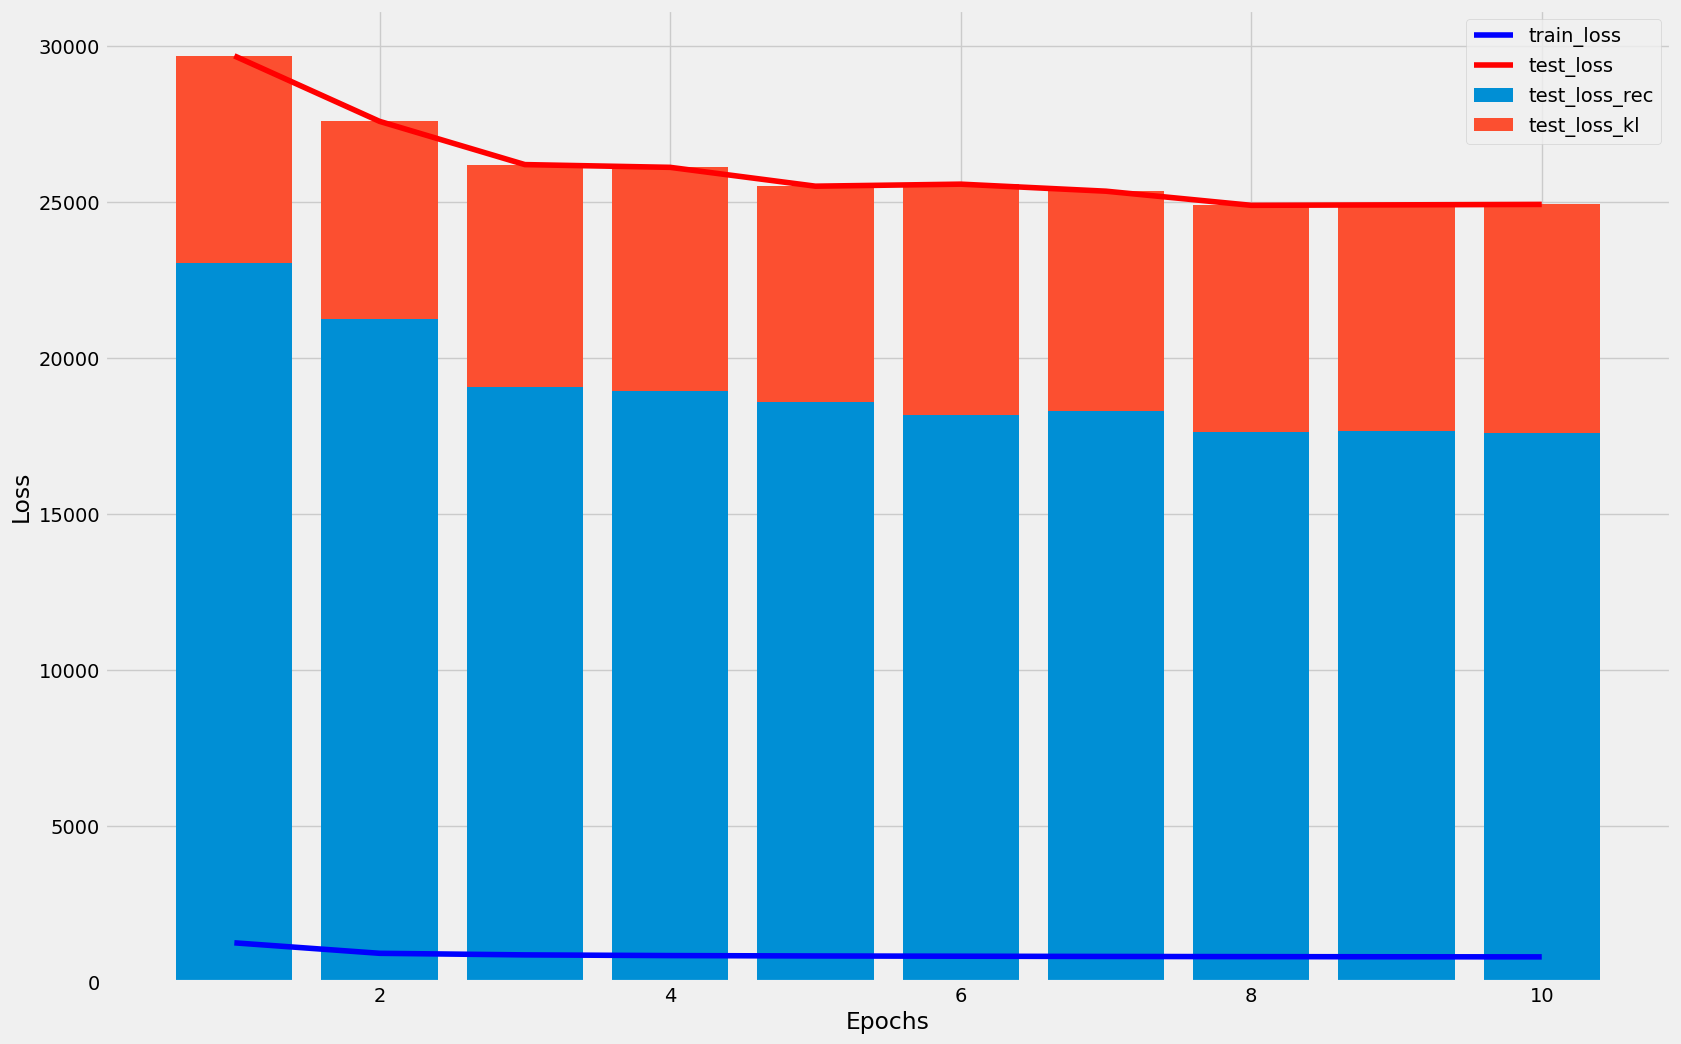

In [27]:
plt.figure(figsize=(18, 12))
plt.xlabel('Epochs')
plt.ylabel('Loss')
epochs = len(pelosses)
plt.plot(torch.arange(epochs) + 1, pelosses, 'b-', label="train_loss")
plt.plot(torch.arange(epochs) + 1, pelosses_test, 'r-', label="test_loss")
plt.bar(torch.arange(epochs) + 1, pelosses_test_rec, label="test_loss_rec")
plt.bar(torch.arange(epochs) + 1, pelosses_test_kl, bottom=pelosses_test_rec, label="test_loss_kl")
plt.legend()

In [28]:
def plot_samples_vae(dataset, model):
    n = 10
    m = 1
    model.to("cpu")
    indices = torch.randint(len(dataset), size=(n,))
    cols, rows = n, m + 1
    figure = plt.figure(figsize=(18, (m + 1) * 2))
    for i in range(n):
        idx = indices[i].item()
        img, label = dataset[idx]
        figure.add_subplot(rows, cols, i + 1)
        plot_img(img.numpy(), "")

        figure.add_subplot(rows, cols, n + i + 1)
        img, label = dataset[idx]
        img = model.reconstruct(img).detach().numpy()
        plot_img(img, "")
    plt.show()

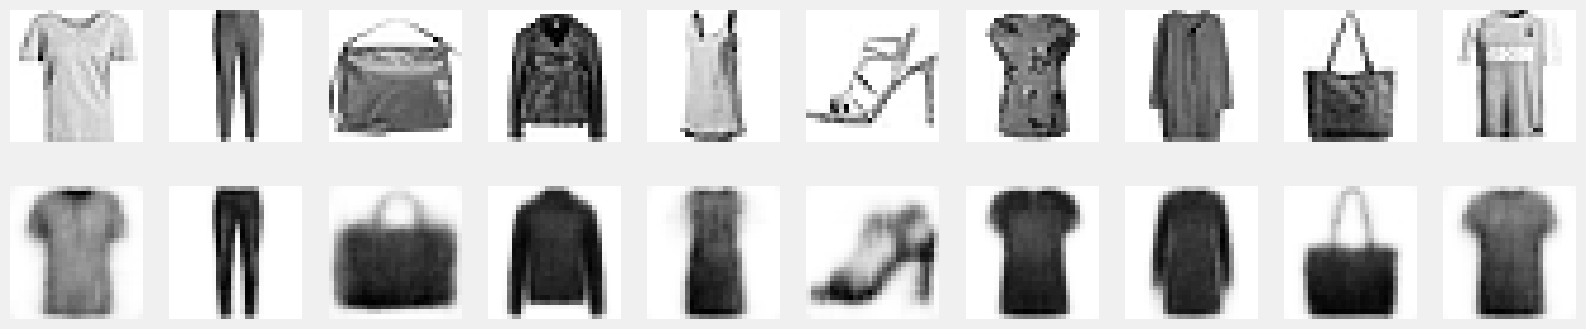

In [29]:
plot_samples_vae(testset, vae)

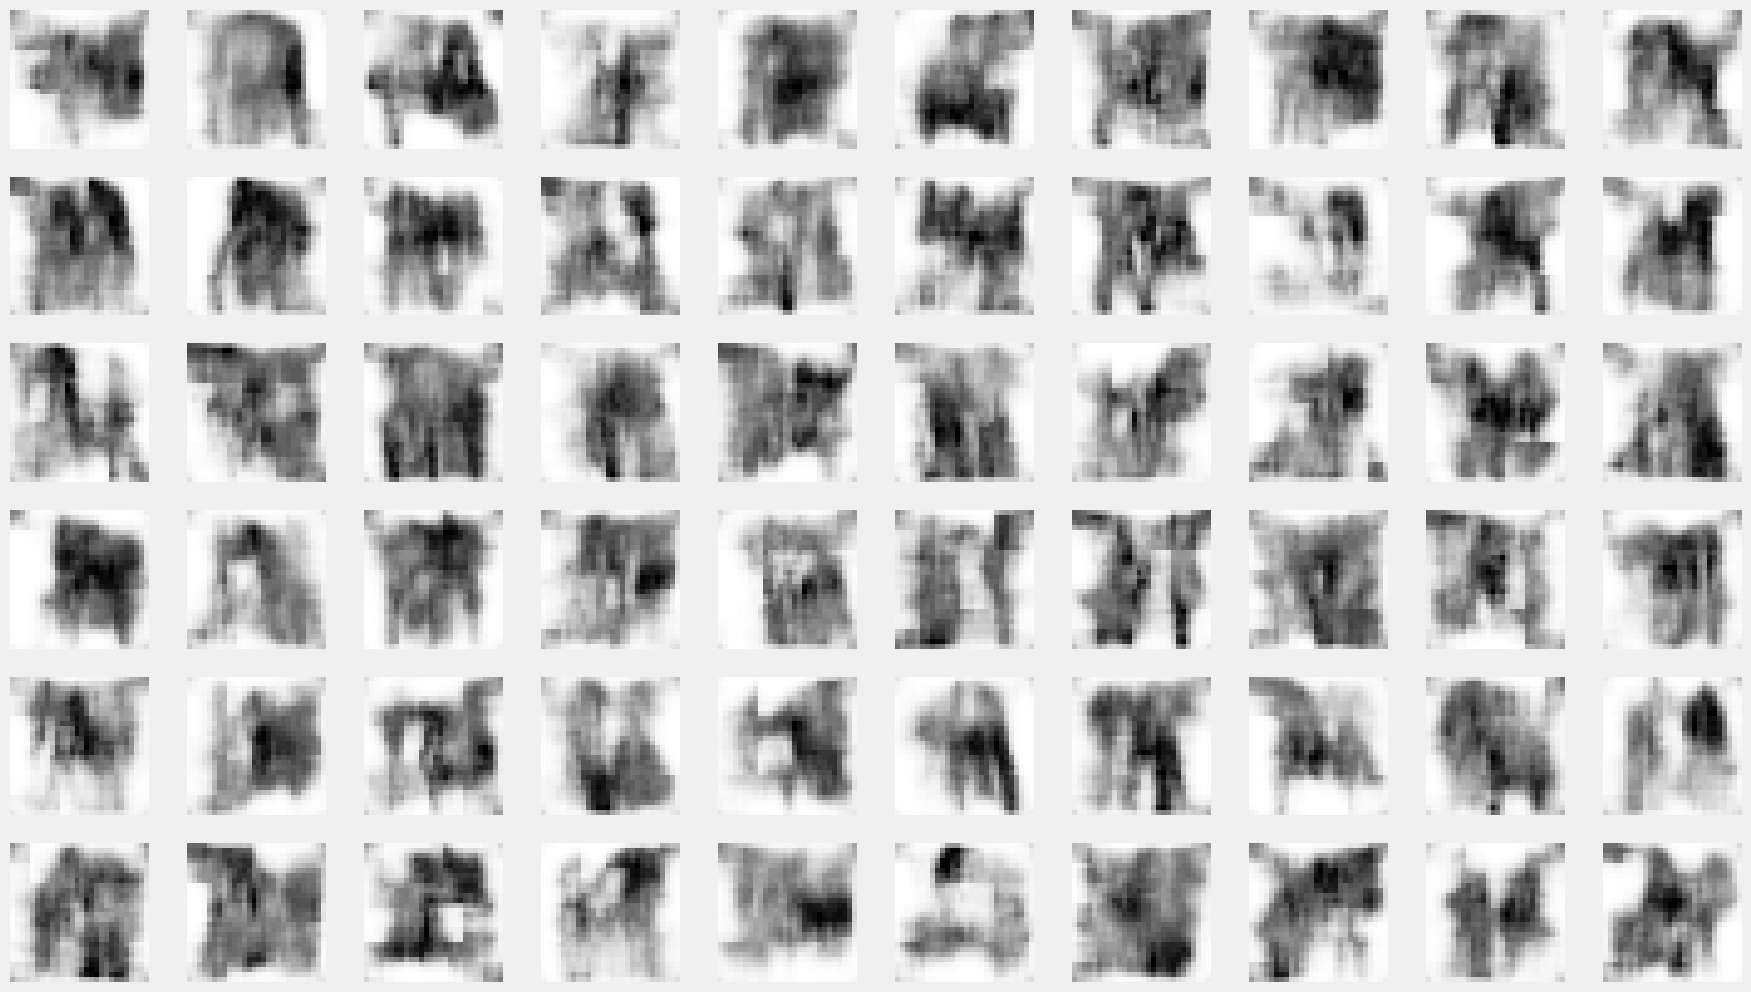

In [30]:
def generated(model):
    cols = 10
    rows = 6
    model = model.to("cpu")
    plt.figure(figsize=(20, rows*2))
    ax = plt.subplot(rows, cols, 1)
    for j in range(rows):
        for i in range(cols):
            z = torch.randn((model.d * 4,)).view(-1,model.d,2,2)
            rec = model.decoder(z).detach().numpy()        
            ax = plt.subplot(rows, cols, j*cols+i+1)
            plot_img(rec.reshape(28,28), "")
    plt.show()
generated(vae)